In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
df=pd.read_csv('C:\\workplace\\electricity_demand\\dataset\\AEP_hourly.csv',index_col=0)
df.columns=['aep_mw']

<Axes: xlabel='Datetime'>

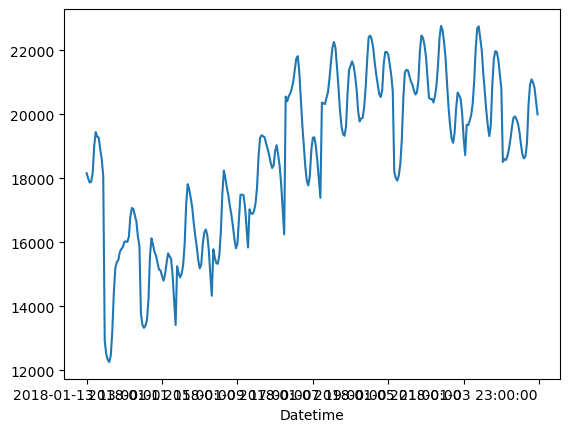

In [2]:
df['aep_mw'].tail(300).plot()

- data is defference as follow:

    - differencing to deterend the dataset

    - eliminate daily and weekly seasonality.

- That is:

$$Y_t=X_t-X_{t-1}-X_{t-24}+X_{t-25}-X_{t-168}+X_{t-169}+X_{t-192}-X_{t-193}.$$

In [3]:
df['log_aep_mw']=np.log(df['aep_mw'])
df['log_aep_mw_diff']=df['log_aep_mw'].diff(1).diff(24).diff(168)
df.dropna(inplace=True)
df.head()

,aep_mw,log_aep_mw,log_aep_mw_diff
Datetime,,,
2004-12-23 02:00:00,14851.0,9.605822,-0.024551
2004-12-23 03:00:00,14441.0,9.577827,-0.026351
2004-12-23 04:00:00,14105.0,9.554285,-0.018322
2004-12-23 05:00:00,14048.0,9.550235,-0.004925
2004-12-23 06:00:00,14394.0,9.574567,-0.012442


In [4]:
df.tail()

,aep_mw,log_aep_mw,log_aep_mw_diff
Datetime,,,
2018-01-01 20:00:00,21089.0,9.956507,0.012940
2018-01-01 21:00:00,20999.0,9.952230,0.014975
2018-01-01 22:00:00,20820.0,9.943669,0.013675
2018-01-01 23:00:00,20415.0,9.924025,0.009949
2018-01-02 00:00:00,19993.0,9.903137,0.005950


In [5]:
train_df=df.iloc[:-168*52+1]

In [6]:
dateTimeIndex=df.iloc[-168*52+1:].index
dateTimeIndex[0]

'2017-06-01 00:00:00'

# Section 1: Fitting the model 

## Section 1.1: Preparing the dataset for fitting the model

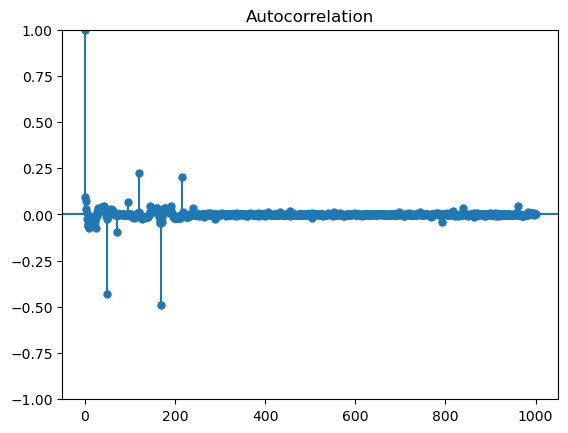

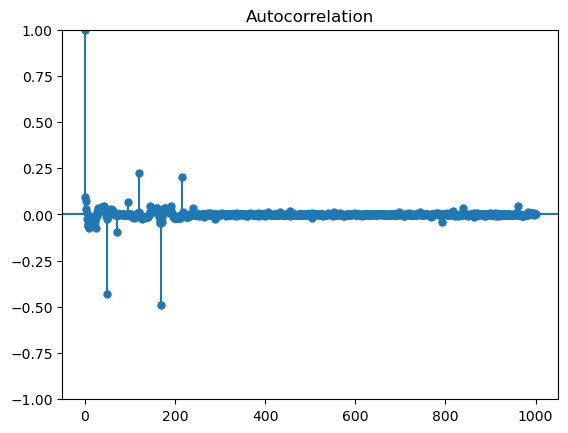

In [7]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df['log_aep_mw_diff'],lags=1000)

In [8]:
def preparion (df,num_lags,lag_feature):
    df_prpocessed=pd.DataFrame(index=df.index,columns=['lags_{}'.format(i) for i in range(num_lags)]+['target'])
    df_prpocessed['target']=df['log_aep_mw_diff'].shift(-1)
    
    for i in range(num_lags):
        df_prpocessed['lags_{}'.format(i)]=df['log_aep_mw_diff'].shift(i)

    df_prpocessed.dropna(inplace=True)

    return np.array(df_prpocessed.drop('target',axis=1)),np.array(df_prpocessed['target'])

In [10]:
X,y=preparion(df,168*4,'log_aep_mw_diff')

## Section 1.2: Hyperparametertuning:

In [33]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [34]:
def xgb_val(train_np,params,test_size,fold_number):

    tree_method=params['tree_method']
    objective_function=params['objective_function']
    num_trees_vec=params['n_estimators']
    depth_vec=params['max_depth']
    eta_vec=params['eta']

    prediction_dict={}
    count=1

    for n_estimators in num_trees_vec:
        fit_np,val_np=train_test_split(train_np,random_state=None,test_size=test_size)

        X_fit=fit_np[:,:-1]
        y_fit=fit_np[:,-1]

        X_val=val_np[:,:-1]
        y_val=val_np[:,-1]

        for depth in depth_vec:
            for eta in eta_vec:
                model=XGBRegressor(objective=objective_function,           
                                    n_jobs=-1,tree_method=tree_method,
                                    n_estimators=n_estimators,max_depth=depth,learning_rate=eta)
                model.fit(X_fit,y_fit)  
                pred=model.predict(X_val)
                score=mean_absolute_error(y_val,pred)
                prediction_dict['model_{}_fold_number_{}'.format(count,fold_number)]=[n_estimators,depth,eta,score]
                print(prediction_dict['model_{}_fold_number_{}'.format(count,fold_number)])
                count=count+1

    prediction_dict=pd.DataFrame(prediction_dict)
    prediction_dict.index=pd.Series(['n_estimators','max_depth','learning_rate','r2_test'])
    prediction_dict=prediction_dict.transpose()
    return prediction_dict.sort_values('auc',ascending=False)

In [35]:
train_np=np.concatenate((X,y.reshape((-1,1))),axis=1)
params={'n_estimators':[100,200,300],'max_depth':[3,5,8],'eta':[0.1],'tree_method':'hist','objective_function':'reg:squarederror'}

In [36]:
a=xgb_val(train_np,params,0.3,1)

[100, 3, 0.1, 0.012095404766602851]
